# Character-Level RNN for Text Generation

This notebook implements a simple [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network) model using [PyTorch](https://pytorch.org/) for character-by-character text generation. It learns from an initial distribution of text (i.e. a corpus).

The code is inspired by Andrej Karpathy's blog post "[The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)", in particular his [minimal character-level RNN-based language model](https://gist.github.com/karpathy/d4dee566867f8291f086).

## Loading the data

In [1]:
from google.colab import files

uploaded_files = files.upload()

Saving warpeace_input.txt to warpeace_input.txt


In [2]:
input_file = next(iter(uploaded_files.keys()))
print(f'Training on corpus "{input_file}"')

Training on corpus "warpeace_input.txt"


In [3]:
with open(input_file) as f:
    corpus = f.read()

print(f'Loaded text corpus with a length of', len(corpus), 'characters')

Loaded text corpus with a length of 3196213 characters


In [4]:
from typing import List, Tuple

alphabet: List[str] = list(set(corpus))
alphabet.sort()

alphabet: Tuple[str, ...] = tuple(alphabet)

ALPHABET_SIZE = len(alphabet)

print('Alphabet consists of', ALPHABET_SIZE, 'distinct symbols')

Alphabet consists of 83 distinct symbols


In [5]:
character_to_index_lookup = { ch:index for index, ch in enumerate(alphabet) }
index_to_character_lookup = { index:ch for index, ch in enumerate(alphabet) }

def str_to_tokens(sequence: str) -> Tuple[int, ...]:
    return tuple(character_to_index_lookup.get(ch) for ch in sequence)

def tokens_to_str(sequence: Tuple[int, ...]) -> str:
    return ''.join(index_to_character_lookup.get(index) for index in sequence)

test_str = "Hello!"
print(f"The string '{test_str}' gets converted to", str_to_tokens(test_str))

test_tokens = str_to_tokens('world')
print("The token sequence", test_tokens, f"gets converted to '{tokens_to_str(test_tokens)}'")

The string 'Hello!' gets converted to (33, 56, 63, 63, 66, 2)
The token sequence (74, 66, 69, 63, 55) gets converted to 'world'


## Defining the neural network

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

SEQUENCE_LENGTH = 25
INPUT_LAYER_SIZE = ALPHABET_SIZE
OUTPUT_LAYER_SIZE = ALPHABET_SIZE
HIDDEN_LAYER_SIZE = 128

class RecurrentNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_to_hidden = nn.Parameter(torch.zeros(INPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE))

        self.hidden_to_hidden = nn.Parameter(torch.zeros(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE))
        self.hidden_bias = nn.Parameter(torch.zeros(1, HIDDEN_LAYER_SIZE))

        self.hidden_to_output = nn.Parameter(torch.zeros(HIDDEN_LAYER_SIZE, OUTPUT_LAYER_SIZE))
        self.output_bias = nn.Parameter(torch.zeros(1, OUTPUT_LAYER_SIZE))
    
    @torch.no_grad()
    def init_weights(self):
        """Randomly initializes the network parameters' values
        using Xavier initialization.
        """
        gain = nn.init.calculate_gain(nonlinearity='tanh')

        nn.init.xavier_uniform_(self.input_to_hidden, gain)

        nn.init.xavier_uniform_(self.hidden_to_hidden, gain)
        nn.init.xavier_uniform_(self.hidden_bias, gain)

        nn.init.xavier_uniform_(self.hidden_to_output, gain)
        nn.init.xavier_uniform_(self.output_bias, gain)
    
    def forward(self, input, hidden):
        assert input.shape[1] == INPUT_LAYER_SIZE
        assert hidden.shape[1] == HIDDEN_LAYER_SIZE

        transformed_input = input @ self.input_to_hidden
        transformed_hidden = hidden @ self.hidden_to_hidden

        hidden = transformed_input + transformed_hidden + self.hidden_bias
        hidden = F.tanh(hidden)

        output = hidden @ self.hidden_to_output + self.output_bias

        return output, torch.sum(hidden.detach(), dim=0).unsqueeze(0)

## Initializing the neural network

In [14]:
torch.manual_seed(97)

network = RecurrentNeuralNetwork()
network.init_weights()

print(next(network.parameters()))

Parameter containing:
tensor([[-1.3620e-01, -7.6492e-02, -6.7240e-02,  ..., -1.8993e-04,
          1.9928e-01, -1.8733e-01],
        [-2.2134e-01,  1.4593e-01,  2.7500e-01,  ..., -1.2844e-01,
          2.7792e-01, -2.5578e-01],
        [ 2.2537e-01,  1.1780e-01,  7.3701e-02,  ...,  1.7910e-01,
          1.9974e-01,  1.9591e-01],
        ...,
        [ 1.4133e-01,  1.6065e-01,  2.7550e-01,  ..., -9.1620e-02,
         -6.9303e-03,  1.7046e-01],
        [-3.0046e-02,  2.2419e-01,  1.1636e-01,  ...,  2.7351e-01,
          1.2189e-01,  9.7406e-02],
        [ 1.0129e-01, -2.5047e-01, -7.9409e-02,  ..., -1.7535e-01,
          4.4654e-03,  2.5592e-01]], requires_grad=True)


In [20]:
from numpy.random import default_rng
rng = default_rng(seed=12345)

@torch.no_grad()
def sample(initial_character, hidden_state, length):
    current_token = character_to_index_lookup[initial_character]
    generated_sequence = [current_token]

    for i in range(SEQUENCE_LENGTH):
        current_token_tensor = torch.tensor((current_token,))
        current_input = F.one_hot(current_token_tensor, num_classes=ALPHABET_SIZE)
        current_input = current_input.float().reshape(1, -1)

        current_output, hidden_state = network.forward(current_input, hidden_state)
        current_probs = F.softmax(current_output, dim=-1).double()

        # Avoid precision issues with numpy
        current_probs /= current_probs.sum()

        next_token = rng.choice(range(ALPHABET_SIZE), p=current_probs.ravel())
        generated_sequence.append(next_token)
        current_token = next_token
    
    return repr(tokens_to_str(generated_sequence))

sample('T', torch.zeros(1, 128), 10)

'"Therded appess by him\\nNat\'"'

In [16]:
import torch.optim as optim

optimizer = optim.Adam(network.parameters())
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [32]:
checkpoint = torch.load('model.pt')

network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [17]:
losses = []

In [ ]:
network.train()

# Clip the gradients of the network's parameters to the range
# [-GRADIENT_CLIP_VALUE, +GRADIENT_CLIP_VALUE] to avoid the problem of
# exploding gradients
GRADIENT_CLIP_VALUE = 5

# How many epochs to train for
# (i.e. how many full passes to perform through the whole input corpus)
num_epochs = 5

for epoch in range(num_epochs):
    print(f"=== Training Epoch #{epoch + 1} ===")

    hidden_state = torch.zeros(1, HIDDEN_LAYER_SIZE, requires_grad=False)

    total_loss = 0.0

    cursor = 0
    while cursor < len(corpus):
        # Get the next sequences of characters to train on
        start = cursor
        end = cursor + SEQUENCE_LENGTH

        input_sequence = corpus[start : end]
        target_sequence = corpus[start + 1 : end + 1]

        # Pad with spaces if we ran over the end of the corpus
        if end > len(corpus):
            input_sequence = input_sequence.rjust(SEQUENCE_LENGTH, ' ')
            target_sequence = target_sequence.rjust(SEQUENCE_LENGTH, ' ')

        # Conver the characters to token indices
        input_sequence_tokens = str_to_tokens(input_sequence)
        target_sequence_tokens = str_to_tokens(target_sequence)

        # One-hot encode the token indices
        input_sequence_tensor = torch.tensor(input_sequence_tokens,
                                             requires_grad=False)
        target_sequence_tensor = torch.tensor(target_sequence_tokens,
                                              requires_grad=False)

        encoded_input_sequence = F.one_hot(input_sequence_tensor,
                                           num_classes=ALPHABET_SIZE)
        encoded_input_sequence = encoded_input_sequence.float()

        # Zero out the accumulated gradients
        optimizer.zero_grad()
        
        loss = torch.tensor(0, dtype=torch.float32)

        # Train on the current sequence
        for i in range(SEQUENCE_LENGTH):
            input_token = encoded_input_sequence[i].unsqueeze(0)
            target_token = target_sequence_tensor[i].unsqueeze(0)

            # Feed-forward pass
            output_logits, hidden_state = network.forward(input_token, hidden_state)

            # We are going to accumulate the loss for each entire sequence in the batch,
            # then perform a single error backpropagation pass
            loss += F.cross_entropy(output_logits, target_token)
        
        # Perform backprop
        loss.backward()

        # Clip gradients
        nn.utils.clip_grad_norm_(network.parameters(), GRADIENT_CLIP_VALUE)

        optimizer.step()

        losses.append(loss.item())
        total_loss += loss.item()
        cursor += SEQUENCE_LENGTH

        if (cursor // SEQUENCE_LENGTH) % 250 == 0:
            print("Current mean loss:", total_loss / cursor)
        if (cursor // SEQUENCE_LENGTH) % 1000 == 0:
            print("Sampled text:", sample(corpus[cursor], hidden_state.clone(), SEQUENCE_LENGTH))
            print()
        
        if (cursor // SEQUENCE_LENGTH) % 5000 == 0:
            # Save a checkpoint of the current model
            # Code based on https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
            state = {
                'epoch': epoch,
                'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }
            torch.save(state, 'model.pt')

    print("Mean total loss:", total_loss / len(corpus))

In [29]:
np.save('losses.npy', losses)

In [30]:
losses = np.load('losses.npy').tolist()

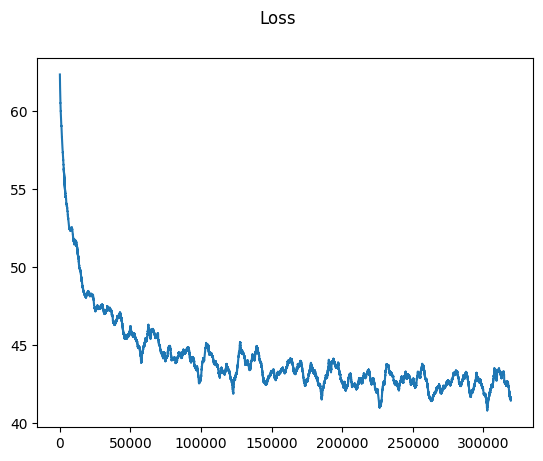

In [31]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.suptitle("Loss")
plt.plot(np.convolve(losses, np.ones(5000), 'valid')/5000)
plt.show()